In [2]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/00_abdomen_cropped.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [8]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

kidney = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=0, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=0, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=0, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=30, scale=0.0001, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=0, scale=0.0005, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)
bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7) # Running simulations with high sos tissue requires a larger grid_lambda parameter to maintain stability

kidney_file_dir = f"{parent}/assets/kidney_phantom"
kidney_tissue_list = [fat, muscle, muscle, bone, cortex, cortex, medulla, medulla, blood]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added fat
Added muscle
Added muscle
Added bone
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_cortex
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_cortex
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_medulla
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added renal_medulla
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
Added blood


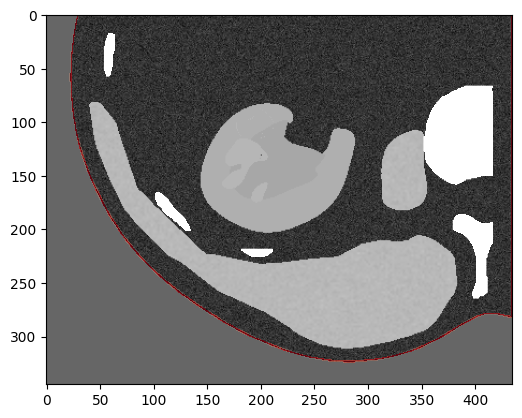

In [12]:
index = 235
plt.imshow(test_phantom.get_complete()[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index], alpha=(body_mask[:,:, index]>0)*0.9, cmap='Reds')

In [13]:
num_transducers = 1
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 3, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 120-3,
                                  focus_elevation = 120-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [14]:
pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[220,70,340], voxel_size[0])
transducer_pose = geometry.Transform(rotation=(np.pi * 0.65, np.pi * 0.15, np.pi * 0.6), translation=pt)
test_transducer_set.assign_pose(0, transducer_pose)

In [15]:
# pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[220,70,310], voxel_size[0])
# normal = -normal
# normal = np.array([normal[0] + 0.3, normal[1] - 0.3, normal[2] - 0.3])
# normal = normal / np.linalg.norm(normal)
# pose = geometry.Transform.make_from_heading_vector(normal, pt)
# theta = np.pi * .45
# about_nl_axis = geometry.Transform(rotation=tuple(theta * normal), translation=(0,0,0), about_axis=True)
# transducer_pose = about_nl_axis * pose
# test_transducer_set.assign_pose(0, transducer_pose)

In [16]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

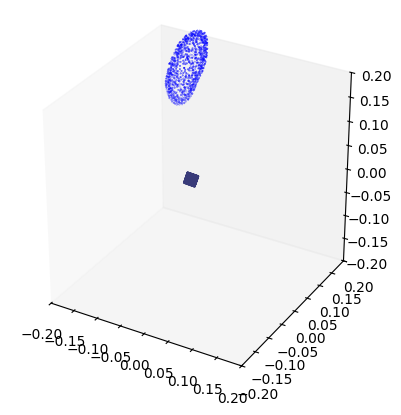

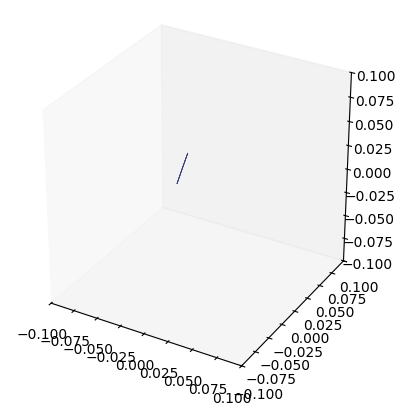

In [25]:
test_transducer_set.plot_transducer_coords(scale=0.2, phantom_coords = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/04_VH_M_kidney_capsule_L.obj")).sample_points_uniformly(1000).points))
# test_transducer_set.plot_transducer_coords(scale=0.2, phantom_coords = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/00_abdomen_cropped.obj")).sample_points_uniformly(1000).points))
test_transducer_set.plot_transducer_fovs()

In [20]:
simprops = simulation.SimProperties(
                grid_size   = (180e-3,90e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [21]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers specifies the number of simultaneous simulations running on a single gpu node, setting workers higher than 3 will likely use more RAM without decreasing overall runtime


In [22]:
sensor_coord = np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test_phantom.matrix_dims)/2
sensor_coord

array([226.22904241,  62.82119334, 339.50161505])

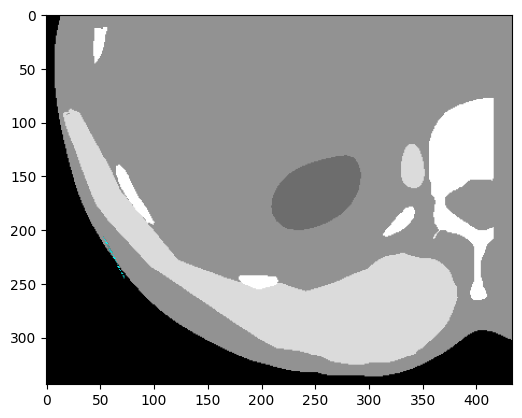

In [23]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_coord[2]))], body_surface_mask=body_mask)

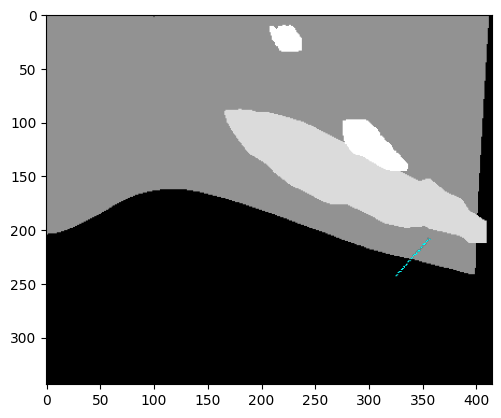

In [24]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1),int(np.round(sensor_coord[1])), slice(0, -1, 1), ], body_surface_mask=body_mask)

(62431200, 3)
(62431200,)


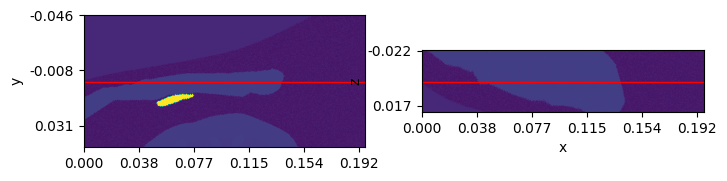

In [3]:
test_experiment.plot_ray_path(0)

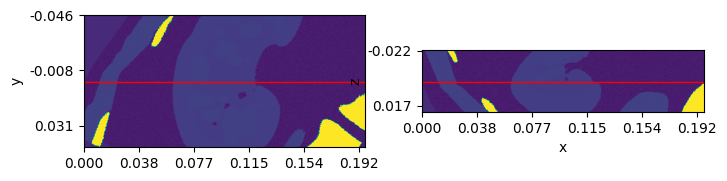

In [19]:
test_experiment.plot_ray_path(31)

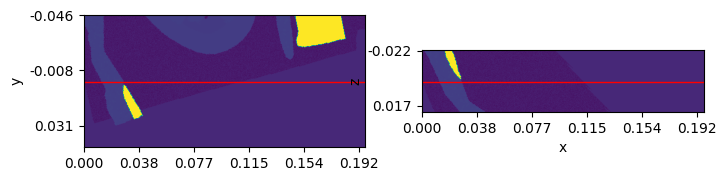

In [21]:
test_experiment.plot_ray_path(-1)

In [2]:
test_experiment = experiment.Experiment.load('../experiment_files/kidney_experiment_02')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


In [23]:
test_experiment.run(repeat=True)

running with 5 workers

preparation for sim   32 completed in 42.67 seconds
preparation for sim    0 completed in 43.95 seconds
preparation for sim   48 completed in 44.00 seconds
preparation for sim   16 completed in 44.30 seconds
preparation for sim   33 completed in 43.77 seconds
preparation for sim   49 completed in 44.18 seconds
preparation for sim    1 completed in 44.37 seconds
preparation for sim   17 completed in 42.45 seconds
simulation            32 completed in 82.22 seconds
simulation             0 completed in 75.92 seconds
simulation            48 completed in 80.11 seconds
simulation            16 completed in 76.10 seconds
preparation for sim   50 completed in 42.27 seconds
preparation for sim    2 completed in 43.53 seconds
preparation for sim   34 completed in 42.78 seconds
preparation for sim   18 completed in 46.99 seconds
simulation            33 completed in 81.35 seconds
simulation             1 completed in 81.93 seconds
simulation            49 completed in 75

In [3]:
test_experiment.add_results()

In [4]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [5]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

100%|██████████| 64/64 [01:07<00:00,  1.06s/it]
1it [00:01,  1.26s/it]


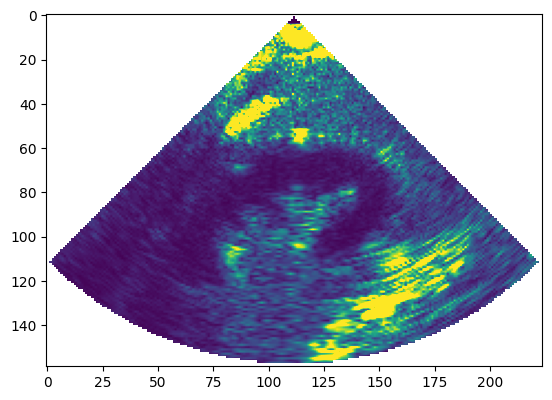

In [6]:
plt.imshow(signals[0], vmax=40000)


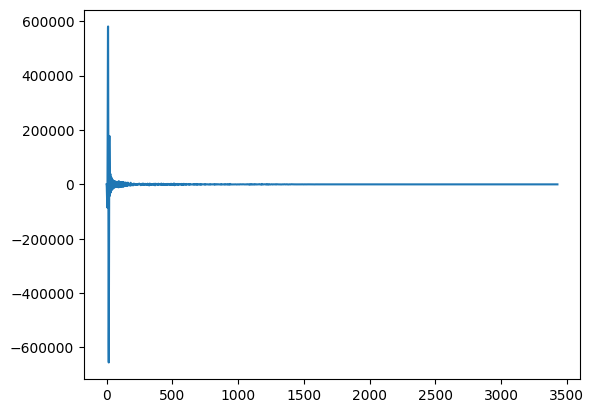

In [7]:
plt.plot(test_experiment.results[9][1][0])

In [8]:
test_experiment.results[0][1][0]

array([ 0.00000000e+00, -1.92608320e+03, -9.17542304e+03, ...,
        3.43995740e+00,  4.64990160e+00,  5.67976393e+00])